## Project: Domain Classification

# Goal:
* To classify text descriptions into Domain & Sub-Domain using Word2Vec for feature extraction and Naïve Bayes for classification.

# Steps Covered
* Load & Explore Dataset
* Text Preprocessing (Tokenization, Lemmatization, Stopword Removal)
* Train Word2Vec Model
* Feature Extraction using Word Embeddings
* Train Naïve Bayes Classifiers (for Domain & Sub-Domain)
* Model Evaluation (Classification Report & Confusion Matrix)
* Data Visualizations (Class Distribution, WordCloud, t-SNE, Confusion Matrix)
* Save Models (For Deployment)
* Deploy using Gradio

# Necessary Installation

In [30]:
!pip install pandas numpy nltk gensim scikit-learn gradio


# =========================================================
# STEP 1: Import Required Libraries
# =========================================================

In [31]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import gradio as gr






In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix



In [33]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# =========================================================
# STEP 2: Load Dataset
# =========================================================

In [34]:
# Load dataset
df = pd.read_csv("dataset_1.csv")


In [35]:
# Display the first few rows
print("Dataset Preview:")
print(df.head())

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Preview:
                                         description         domain  \
0  Streaming in the entertainment domain is the d...  Entertainment   
1  Blockchain is a technology that is used to mak...     Technology   
2  Insurance is a financial sector that deals wit...        Finance   
3  Fintech is the field of finance that deals wit...        Finance   
4  Investments in the Finance domain is the domai...        Finance   

    sub_domain  
0    Streaming  
1   Blockchain  
2    Insurance  
3      Fintech  
4  Investments  

Missing Values:
description    0
domain         0
sub_domain     0
dtype: int64


# =========================================================
# STEP 3: Text Preprocessing
# =========================================================

In [36]:

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization
    return tokens


In [37]:
# Apply preprocessing
df['processed_description'] = df['description'].apply(preprocess_text)

# =========================================================
# STEP 4: Visualizing Data Distribution
# =========================================================

<ipython-input-38-7cbbf66854c5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["domain"], order=df["domain"].value_counts().index, palette="coolwarm")


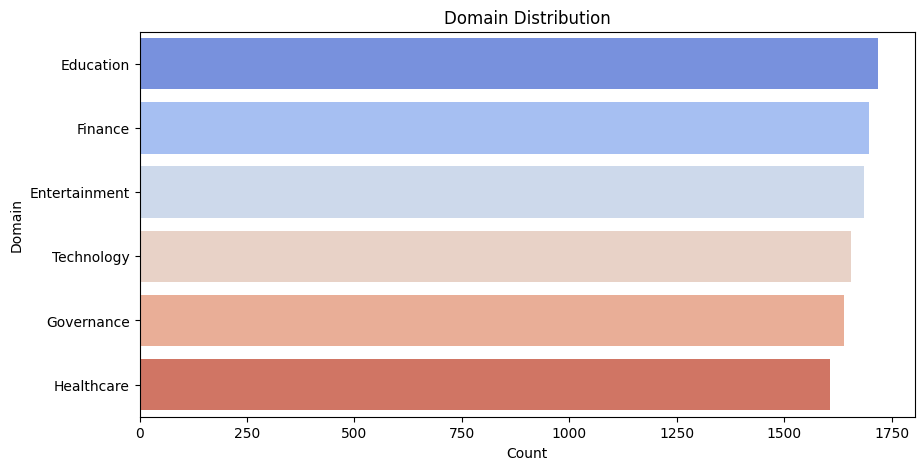

In [38]:
# Plot Domain Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=df["domain"], order=df["domain"].value_counts().index, palette="coolwarm")
plt.title("Domain Distribution")
plt.xlabel("Count")
plt.ylabel("Domain")
plt.show()




<ipython-input-39-fc704711ebc1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["sub_domain"], order=df["sub_domain"].value_counts().index, palette="viridis")


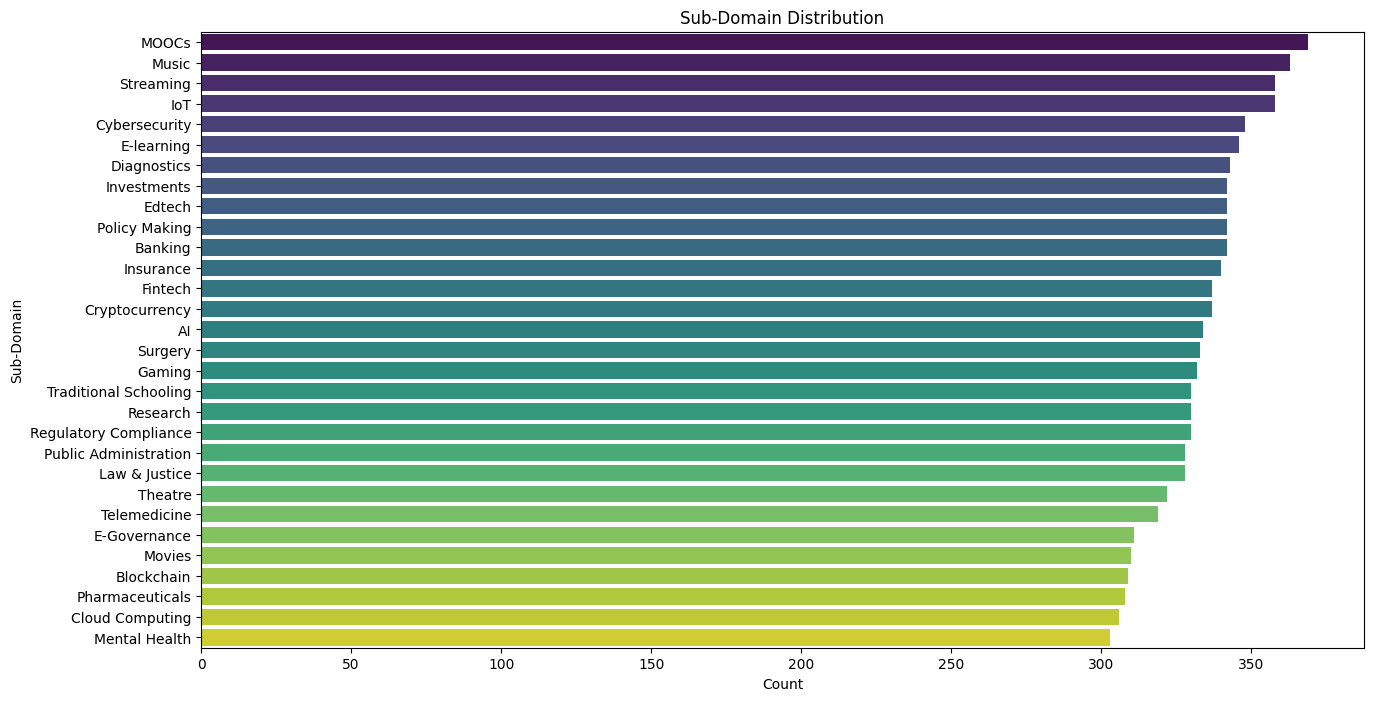

In [39]:
# Sub-Domain Distribution
plt.figure(figsize=(15, 8))
sns.countplot(y=df["sub_domain"], order=df["sub_domain"].value_counts().index, palette="viridis")
plt.title("Sub-Domain Distribution")
plt.xlabel("Count")
plt.ylabel("Sub-Domain")
plt.show()

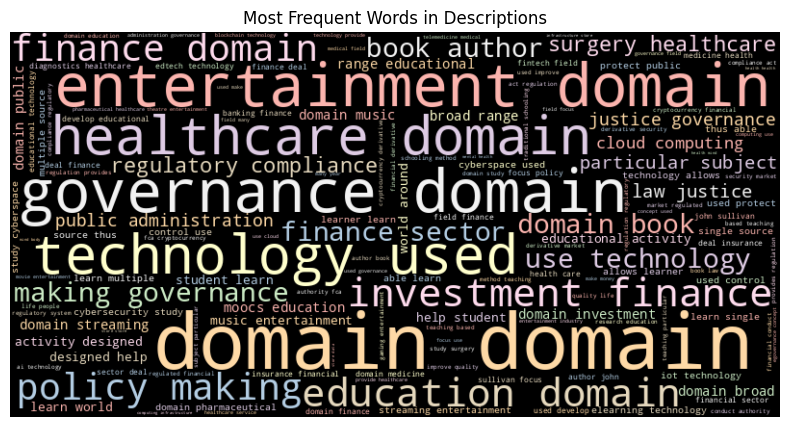

In [40]:
# Generate WordCloud for most common words
text = " ".join([" ".join(words) for words in df["processed_description"]])

wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Pastel1").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Descriptions")
plt.show()


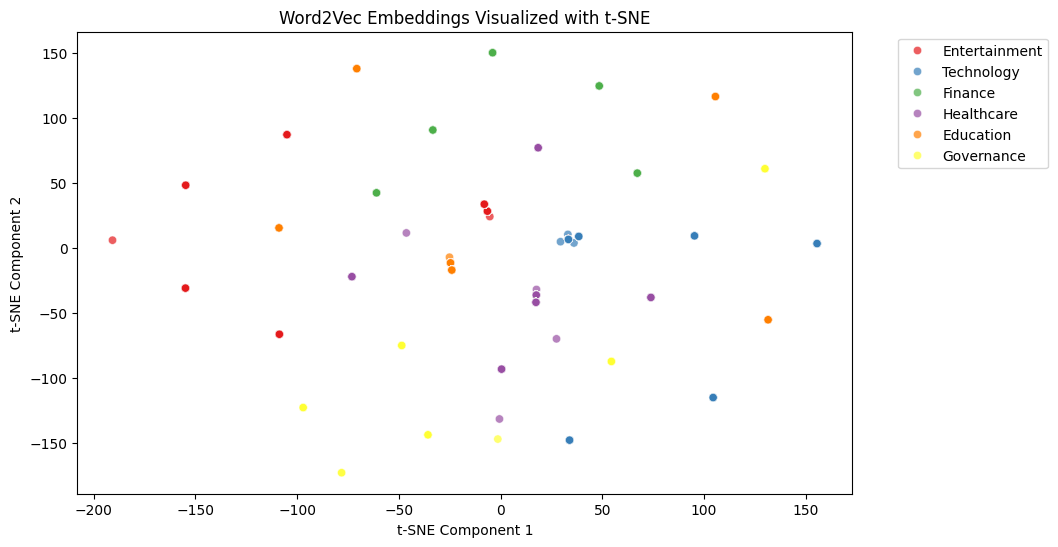

In [41]:
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_reduced = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=word_vectors_reduced[:, 0], y=word_vectors_reduced[:, 1], hue=df["domain"], palette="Set1", alpha=0.7)
plt.title("Word2Vec Embeddings Visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# =========================================================
# STEP 5: Train Word2Vec Model
# =========================================================

In [42]:
# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=df['processed_description'], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv  # Extract word embeddings


In [43]:
# Function to get the average Word2Vec vector for a sentence
def get_sentence_vector(tokens, word_vectors, vector_size=100):
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)



In [44]:
# Convert descriptions into feature vectors
X = np.array([get_sentence_vector(tokens, word_vectors) for tokens in df['processed_description']])
y_domain = df['domain']  # Target variable for domain
y_subdomain = df['sub_domain']  # Target variable for sub-domain


In [45]:
from sklearn.preprocessing import MinMaxScaler

# Normalize feature vectors for Naïve Bayes
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# =========================================================
# STEP 6: Train Naïve Bayes Classifiers
# =========================================================

In [46]:
# Split dataset

# For Domain
X_train, X_test, y_train_domain, y_test_domain = train_test_split(X_scaled, y_domain, test_size=0.2, random_state=42)

# For Sub-Domain
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_scaled, y_subdomain, test_size=0.2, random_state=42)


In [47]:
# Train Naïve Bayes Model for Domain
nb_model_domain = MultinomialNB()
nb_model_domain.fit(X_train, y_train_domain)


MultinomialNB()

In [57]:
# Train Naïve Bayes Model for Sub-Domain
nb_model_subdomain = MultinomialNB()
nb_model_subdomain.fit(X_train_sub, y_train_sub)



MultinomialNB()

# =========================================================
# STEP 7: Model Evaluation
# =========================================================

In [58]:
# Evaluate Models
y_pred_domain = nb_model_domain.predict(X_test)
y_pred_subdomain = nb_model_subdomain.predict(X_test_sub)


# Classification Report For Domain
print("Domain Classification Report:\n", classification_report(y_test_domain, y_pred_domain))


Domain Classification Report:
                precision    recall  f1-score   support

    Education       1.00      0.61      0.76       350
Entertainment       0.82      1.00      0.90       310
      Finance       1.00      1.00      1.00       326
   Governance       1.00      1.00      1.00       355
   Healthcare       1.00      1.00      1.00       335
   Technology       0.83      1.00      0.91       324

     accuracy                           0.93      2000
    macro avg       0.94      0.94      0.93      2000
 weighted avg       0.94      0.93      0.93      2000



In [59]:
# Classification Report For Sub-Domain
print("Sub-Domain Classification Report:\n", classification_report(y_test_sub, y_pred_subdomain))

Sub-Domain Classification Report:
                        precision    recall  f1-score   support

                   AI       1.00      1.00      1.00        76
              Banking       1.00      1.00      1.00        65
           Blockchain       1.00      1.00      1.00        56
      Cloud Computing       1.00      1.00      1.00        59
       Cryptocurrency       1.00      1.00      1.00        62
        Cybersecurity       1.00      1.00      1.00        68
          Diagnostics       1.00      1.00      1.00        73
         E-Governance       1.00      1.00      1.00        63
           E-learning       1.00      1.00      1.00        67
               Edtech       1.00      1.00      1.00        68
              Fintech       1.00      1.00      1.00        54
               Gaming       0.55      1.00      0.71        66
            Insurance       1.00      1.00      1.00        70
          Investments       1.00      1.00      1.00        75
                  I

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Confusion Matrix Plot

In [60]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


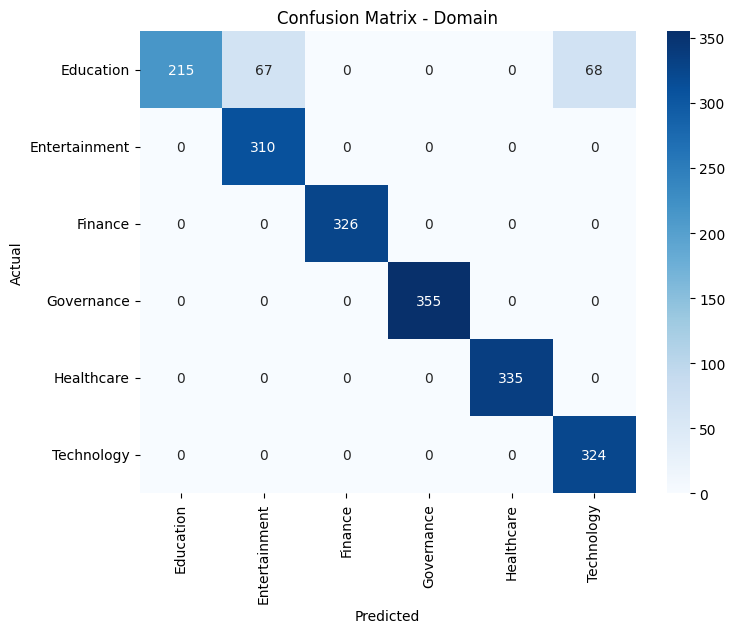

In [51]:
# For Domain
plot_confusion_matrix(y_test_domain, y_pred_domain, "Confusion Matrix - Domain")

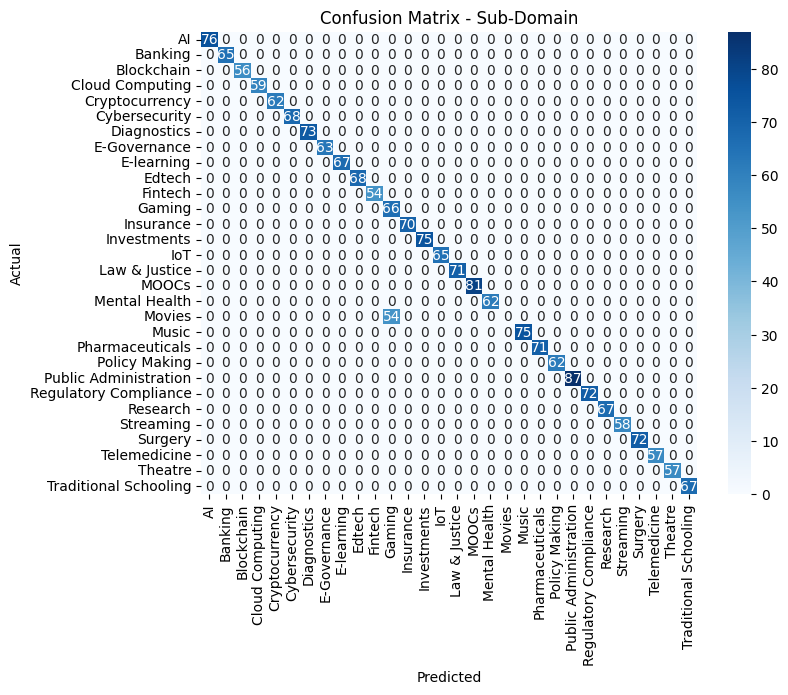

In [52]:
# For Sub-Domain
plot_confusion_matrix(y_test_sub, y_pred_subdomain, "Confusion Matrix - Sub-Domain")

# =========================================================
# STEP 8: Save Trained Models
# =========================================================

In [53]:
joblib.dump(nb_model_domain, "naive_bayes_domain.pkl")
joblib.dump(nb_model_subdomain, "naive_bayes_subdomain.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(word2vec_model, "word2vec_model.pkl")


['word2vec_model.pkl']

# =========================================================
# STEP 9: Deploy using Gradio
# =========================================================

* Load models

In [54]:
nb_model_domain = joblib.load("naive_bayes_domain.pkl")
nb_model_subdomain = joblib.load("naive_bayes_subdomain.pkl")
scaler = joblib.load("scaler.pkl")
word2vec_model = joblib.load("word2vec_model.pkl")
word_vectors = word2vec_model.wv

In [55]:

# Prediction Function
def predict_domain_subdomain(text):
    tokens = preprocess_text(text)
    vector = get_sentence_vector(tokens, word_vectors).reshape(1, -1)
    vector_scaled = scaler.transform(vector)

    domain_prediction = nb_model_domain.predict(vector_scaled)[0]
    subdomain_prediction = nb_model_subdomain.predict(vector_scaled)[0]

    return f"Domain: {domain_prediction}\nSub-Domain: {subdomain_prediction}"



*  Gradio UI

In [56]:
interface = gr.Interface(
    fn=predict_domain_subdomain,
    inputs="text",
    outputs="text",
    title="Domain & Sub-Domain Classifier",
    description="Enter a description, and the model will predict the domain and sub-domain."
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81a0ad1cdafc69853c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
